## Classification
이전 Post Ch1,2에서는 Label이 Continuous한 Value로서 Regression으로서 Prediction하였다.  
이번 Post는 Label이 Category인 Classification에 대하여 알아보자.

## Setup
실제 Project를 진행하기 앞서 사용하고자 하는 Library확인 및 원하는 Version(Python 언어 특성상 Version에 많이 의존하게 된다.)이 설치되어있는지 확인하는 작업이다.  
또한, 자주 사용하게 될 Function이나, Directory를 지정하기도 한다.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST
Classification에서 알아볼 Dataset은 MNIST이다. MNIST는 손글씨 Dataset으로서 28x28의 Image가 Input으로서, 그 이미지가 어떤 숫자인지 Label이 묶여있는 Dataset이다.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print('Input X.shape',X.shape)
print('Label y.shape',y.shape)

# y:str -> int
y = y.astype(np.uint8)

print('Input X.type',type(X[0][0]))
print('Input y.type',type(y[0]))

Input X.shape (70000, 784)
Label y.shape (70000,)
Input X.type <class 'numpy.float64'>
Input y.type <class 'numpy.uint8'>


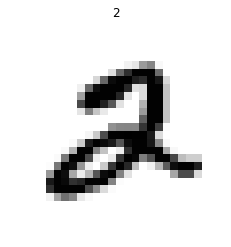

In [35]:
def plot_digit(data,label=True):
    image = data.reshape(28, 28)
    if label:
        plt.title(str(label))
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(X[5],y[5])

In [5]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


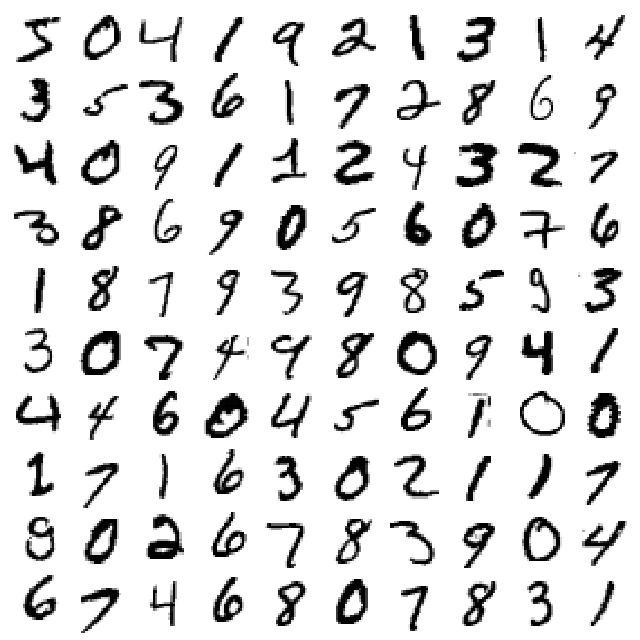

In [6]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

위와 같은 구성을 가지는 MNIST Image를 Train, Test set으로서 분류한다.  
참고사항으로 Data를 Random하게 섞는 것은 Model의 성능을 향상시키나, 시계열 데이터(Time Series)같은 Data는 Shuffle시 성능이 떨어질 수 있다.

In [7]:
import numpy as np

index = int(len(X)*0.8)
shuffle_index = np.random.permutation(index)

# Split
X_train, X_test, y_train, y_test = X[:index], X[index:], y[:index],y[index:]
# Shuffle
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier
True or False, 0 or 1 처럼 둘 중 하나를 분류하는 문제를 사용하여 나타낸다.  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html">sklearn.lenar_model.SGDClassifier</a>를 사용하며 SVM(default) or Logestic regression... 등을 <a href="https://wjddyd66.github.io/dl/NeuralNetwork-(3)-Optimazation/#gradient-descent">SGD optimizer</a>를 사용하여 분류를 한다.  

아래 예시는 y(label)이 5인지 아닌지에 대하여 분류하는 방법이다.

In [8]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

some_x = X_test[:10]
some_label = y_test_5[:10]

sgd_clf = SGDClassifier(max_iter=2000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)
print('Original Test label: ',some_label)
print('Model Prediction label: ',sgd_clf.predict(some_x))

Original Test label:  [False False  True False False False False False False False]
Model Prediction label:  [False  True  True False False False False False False False]


## Perfomance measurement

### Cross Validation
Ch2 에서 수행한 교차검증 방법에는 2가지가 있다.  
기본적으로 사용하였던 K-Fold을 사용하거나 <code>sklearn.model_selection.StratifiedKFold</code>를 사용하여 계층적 Sampling의 결과로서 CrossValidation을 수행하는 방법이다.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

print('K-Fold')
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

print('\nStratified K-Fold')
skfolds = StratifiedKFold(n_splits=3,random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

K-Fold
[0.96260781 0.96067927 0.95810565]

Stratified K-Fold
0.9637863609578401
0.9672684416349708
0.9613200471445409


위의 결과는 대략 96%의 정확도를 보여주고 있다.  
아래 Estimator는 모두 False로서 판단하는 Estimator이다.  
이러한 Estimator로서 K-fold시 결과를 살펴보면 다음과 같다.

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.90850163, 0.90769808, 0.91272903])

위의 결과를 살펴보면 대략적으로 90%의 성능을 자랑한다. 0~9까지의 예측중 전부 5가아니라고 판단하였기 때문이다.  
이렇듯 Model에 특성에 따라서 Accuracy가 높다고 하여서 좋은 것은 아니다.  
좀 더 세부적으로 Model을 평가하는 방법에 대해서 알아봐야 될 것 이다.

### Confusion Matrix
K-fold검증이 필요한데 Score로서 판단하는 것이 아닌 Predict로서 판단하게 되면 실제 분류기에서 판단한 결과가 나오게 된다.  
여기에서 sklearn에서 제공하는 Confusion Matrix로서 Confusion Matrix에 대해 알아보자.

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
confusion_matrix(y_train_5,y_train_pred)

array([[50130,   810],
       [ 1404,  3656]], dtype=int64)

위의 Confusion Matrix 결과를 살펴보면 다음과 같다.  

<table class="table">
	<tbody>
	<tr>
		<td></td>
		<td>$\hat{y} = -1$</td>
        <td>$\hat{y} = 1$</td>
	</tr>
	<tr>
		<td>y = -1</td>
		<td>TN</td>
        <td>FP</td>
	</tr>	
	<tr>
		<td>y = 1</td>
		<td>FN</td>
        <td>TP</td>
	</tr>
</tbody>
</table>

$$Precision = \frac{TP}{TP+FP} \text{  :Model이 참이라 하였을 때 실제 참일 확률}$$
$$Recall = \frac{TP}{TP+FN} \text{  :실제 참인데 Model이 참이라 분류할 확률}$$
$$F_1 = \frac{2}{\frac{1}{Precision}+\frac{1}{Recall}} = \frac{TP}{TP+\frac{FN+FP}{2}} \text{  :정밀도와 재형율의 조화평균(harmonic mean)}$$

위의 두가지 모두 Model의 성능을 측정하는데 매우 중요한 지표이다.

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision Score: ',precision_score(y_train_5,y_train_pred))
print('Recall Score: ',recall_score(y_train_5,y_train_pred))
print('F1 Score: ',f1_score(y_train_5,y_train_pred))

Precision Score:  0.8186296462158531
Recall Score:  0.7225296442687748
F1 Score:  0.7675834558051648


정밀도와 재현률에 대하여 예시를 살펴보면 다음과 같다.  
>1. 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정하면. 재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 것들만 노출시키는(높은 정밀도) 분류기를 선호할 것 이다.
2. 감시 카메라를 통해 좀도둑을 잡아내는 분류기를 훈련시킨다고 가정하면, 분류기의 재현률이 99%라면 정확도가 30%만 되더라도 괜찮을 수 있다.(아마도 경비원이 잘못된 호출을 종종 받게 되겠지만, 거의 모든 좀도둑을 잡을 것입니다.)
>

**이러한 정밀도와 재현률은 Tradeoff의 관계를 가지게 된다.**

### Precision/Recall Tradeoff
현재 SGDClassifier는 Decision Function을 사용하여 각 Sample의 점수를 계산한다. (Logistic Regression or SVM이 어떻 조건을 활용(Decision Function)하여 분류하는지는 ch4,5에서 알아보자.)  
<code>.decision_function()</code>으로서 실제 Score를 구할 수 있고 특정 Threshold를 사용하여 Precision과 Recall을 조절할 수 있다.  

**Threshold값을 증가시킨다는 것은 Model이 <span>$\hat{y}=1$</span> 로서 판단하는 데 더많은 제약조건을 걸어서 판단하기 힘들게 만든다는 의미이다.**  

따라서 Threshold가 증가 -> FN 증가, FP 감소 -> Precision증가, Recall 감소

Saving figure precision_recall_vs_threshold_plot


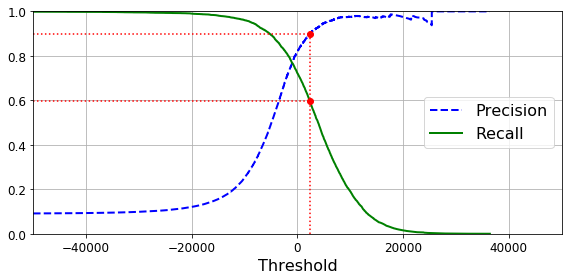

In [13]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

Saving figure precision_vs_recall_plot


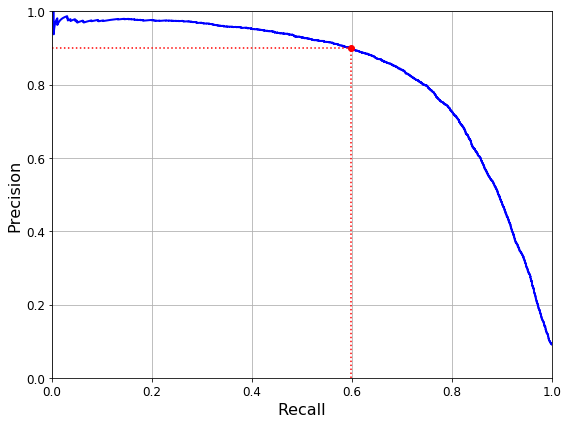

In [14]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [15]:
threshold_90_precision

2373.901256442848

위의 결과를 확인하면 대략적으로 threshold를 2373으로 설정하였을 경우 Precision은 0.9, Recall은 0.6인것을 확인할 수 있다.

In [16]:
y_pred_precision_90 = (y_scores >= threshold_90_precision)
print('Threshold: ',threshold_90_precision)
print('Precision: ',precision_score(y_train_5,y_pred_precision_90))
print('Recall: ',recall_score(y_train_5,y_pred_precision_90))

Threshold:  2373.901256442848
Precision:  0.9
Recall:  0.5976284584980237


### ROC Curve
ROC Curve는 민감도(Recall)에 대한 FPR(1-특이도(Specificity, TNR))의 그래프이다.

$$FPR = \frac{FP}{FP+TN} = 1-TNR$$
위의 식과 Recall을 살펴보게 되면 TN이 증가할수록 FN도 증가할 거라는 것을 알 수 있다.  
ROC Curve를 살펴보면 다음과 같다.

Saving figure roc_curve_plot


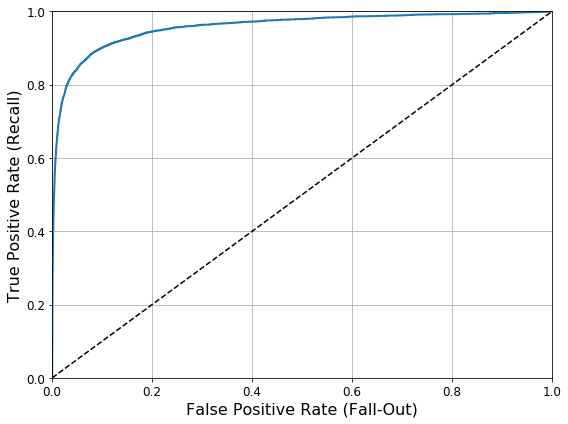

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")                         # Not shown
plt.show()

위와 같은 결과로서 같이 값이 증가한다는 특징 때문에, ROC Curve는 곡선아래의 면적을 계산하는 AUC로서 Model의 성능을 비교한다.

생각해보면 FPR과 TPR이 같이 증가하지만, 완벽한 분류를 하는 Model은 FPR이 0.0일때 TPR은 1.0일 것이고 이러한 Model의 AUC는 1이 될 것이다.  

랜덤하게 분류하는 Dummy Classifier를 생성하고 AUC를 살펴보면 다음과 같다.

c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


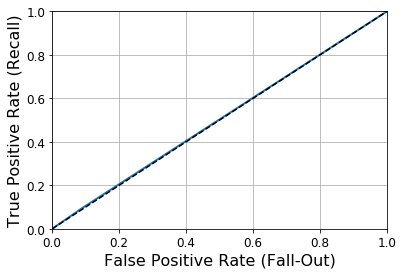

In [25]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## Multiclass classifier
책에서는 Multicalss classifier를 크게 두가지로 나누었다.  
랜덤 포레스트 분류기나 나이브 베이지 분류기 같은 일부 알고리즘은 여러개의 클래스를 직접 처리할 수 있는 반면, SVM 같이 이진 분류만 가능한 알고리즘이 있다.

이진 분류를 MNIST의 Dataset을 분류할때 다음과 같다.


특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0~9)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다. 이미지를 분류할때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택.  
이를 **일대다(OvA - One Versus All, One versus the rest)전략** 이라고 한다.

0과1을 구별, 0과2를 구별, 1과 2구별 등과 같이 각 숫자의 조합마다 이진분류기를 훈련시키는 것 이다. 이를 **일대일(OvO)전략** 이라고 한다.  
즉 MNIST를 OvO전략으로 분류하려면 분류기가 N(N-1)/2 로서 45개가 필요한 것이다.

In [18]:
# Single Class -> Multi Class(OvA)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=2000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
some_label = y_test[:10]
print('Original Label: ',some_label)
print('Model prediction: ',sgd_clf.predict(some_x))

Original Label:  [1 8 5 9 8 0 3 1 3 2]
Model prediction:  [1 5 5 9 8 0 4 1 3 2]


실제 이진 분류기는 총 10개의 분류기가 있고 이러한 분류기에서 각각의 Score를 측정한 뒤 가장 큰 값을 Prediction하는 것 이다.  
아래 결과를 확인하면 실제 Decision Function의 값이 가장 높은 Index를 Model에서 Prediction한 값이라고 표현한 것을 알 수 있다.

In [20]:
some_digits_score = sgd_clf.decision_function(some_x[0].reshape(1,-1))
print('Model prediction: 1')
print(some_digits_score)

Model prediction: 1
[[-27095.55891163   8364.15797562  -2205.69984808  -2868.06316532
   -9694.57411668  -5450.11066327  -8339.68143716  -5126.8562764
     446.43861928  -3314.64761889]]


sklearn에서는  
- OvO: OneVsOne Classifier
- OvA: OneVsRestClassifer

로서 사용 가능하다.

In [21]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=3,random_state=42))
ovo_clf.fit(X_train,y_train)
print('Original Label: ',some_label)
print('Model prediction: ',ovo_clf.predict(some_x))
print('Number of Estimators: ',len(ovo_clf.estimators_))

c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max

c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max

Original Label:  [1 8 5 9 8 0 3 1 3 2]
Model prediction:  [1 5 5 9 8 0 3 1 3 2]
Number of Estimators:  45


c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


마지막으로 Ch2에서 다루었던 Scaling후 Model의 성능을 K-fold를 사용하여 구하면 다음과 같다.

In [22]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.89971608, 0.89784111, 0.89553198])

위의 결과로 대략적으로 89%의 성능을 보여주는 것으로 확인되었다.


## Error Analysis
실제 Error발생을 확인하여 보자.  
Model이 잘 예측하는 지 혹은 잘못 예측하는 곳이 어디가 많이 있는지를 Confusion Matrix로서 살펴볼 수 있으나, 좀 더 살펴보기 쉽게 Visualization하여 살펴보자.

Saving figure confusion_matrix_plot


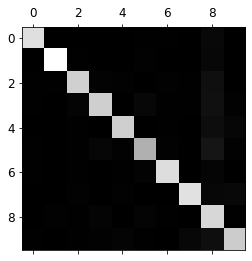

In [23]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train, cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)

# Visualization Confusion Matirx
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot",tight_layout=False)
plt.show()

위의 결과를 살펴보게 되면 ConfusionMarix의 주성분이 밝은색으로 높은값을 의미한다.  
즉, Model이 대부분을 잘 분류하지만, 5의 경우 다른 것보다 많이 잘못 분류하는 경향이 있다.  

각각의 Sample마다 갯수도 다를 수 있으므로 Normalization후, 높은 값을 가지고있는 주성분의 값을 0으로 변환 후 다시 Visualization하면 다음과 같은 결과를 얻을 수 있다.

Saving figure confusion_matrix_errors_plot


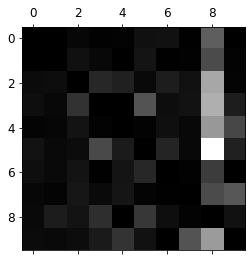

In [24]:
# Normalization
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Drop Diogonal value
np.fill_diagonal(norm_conf_mx, 0)

# Visualization Confusion Matrix
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

위의 결과를 살펴보게 Confusion Matrix 행을 기준으로 많은 수가 8로서 판단되었다는 것을 살필 수 있고, 특히 5와 8을 잘못 판단하는 경우가 많다.  

자세히 알아보기 위하여 Visualization하여 확인하면 다음과 같다.

Saving figure error_analysis_digits_plot


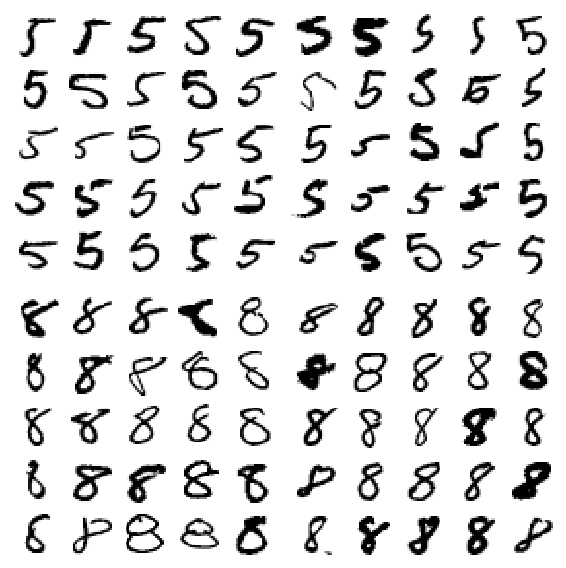

In [26]:
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# Label: 5 but Model: 8
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# Label: 8 but Model: 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

위와 같이 Model의 Error를 Visualization을 하여 파악하면 어떤 조건을 더 주어야 Model의 성능이 향상 될 수 있는지 알 수 있다.( ex) Open CV를 활용하여 동심원이 2개인 것은 8로서 설정한다.)

## Multi Label Classification
Label이 1개가 아니라 여러개의 Label을 포함하는 경우이다.  
즉, MNIST로서 아래 Code와 연관되어 예를 들면 5를 Input으로 넣으면 7보다는 작고, 홀수라는 Prediction결과를 나타낼 것 이다.

In [28]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]


y_test_original = y_test[:5]
y_test_large = (y_test_original>= 7)
y_test_odd = (y_test_original % 2 == 1)
y_test_multilabel = np.c_[y_test_large, y_test_odd]



knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
y_knn_pred = knn_clf.predict(X_test[:5])

print('Original Label')
print(y_test_original)
print('\nChage Label')
print(y_test_multilabel)
print('\nModel Prediction')
print(y_knn_pred)

Original Label
[1 8 5 9 8]

Chage Label
[[False  True]
 [ True False]
 [False  True]
 [ True  True]
 [ True False]]

Model Prediction
[[False  True]
 [ True False]
 [False  True]
 [ True  True]
 [ True False]]


## Multioutput classification
다중 출력을한느 Classification을 만드는 것을 목표로 한다.  
예를들면, Noise가 낀 Dataset을 Input으로 넣으면 깨끗한 Dataset이 Output으로 나오는 Model을 만들기 원한다고 가정하자.  

즉, Output이 다양한 Label이 아닌 다양한 Discrete한 Value(Pixel 값)이 나오는 Model이다.

In [29]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Noise가 낀 Image지와 실제 Image를 비교하면 다음과 같다.

Saving figure noisy_digit_example_plot


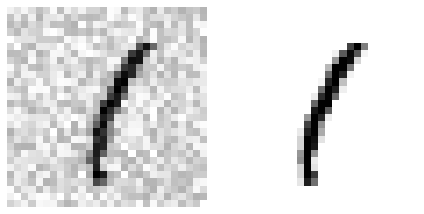

In [37]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index],label=False)
plt.subplot(122); plot_digit(y_test_mod[some_index],label=False)
save_fig("noisy_digit_example_plot")
plt.show()

Model을 Training시키고 Prediction한 결과를 살펴보면 다음과 같다.

Saving figure cleaned_digit_example_plot


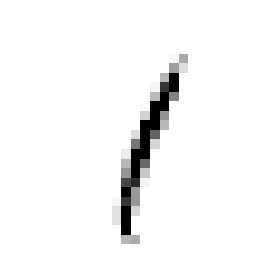

In [39]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit,label=False)
save_fig("cleaned_digit_example_plot")